In [1]:
import numpy as np
import pandas as pd
from main import PredictChurn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
pc = PredictChurn(check_validation=True)
df_results_train, df_results_test = pc.train_model_and_predict()

churn
0    7164
1    1836
Name: count, dtype: int64
churn
0    815
1    185
Name: count, dtype: int64
Train AUC: 0.668
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      7164
           1       0.29      0.62      0.40      1836

    accuracy                           0.62      9000
   macro avg       0.58      0.62      0.56      9000
weighted avg       0.75      0.62      0.65      9000

Test AUC: 0.6434820096169789
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       815
           1       0.26      0.59      0.36       185

    accuracy                           0.61      1000
   macro avg       0.56      0.60      0.54      1000
weighted avg       0.76      0.61      0.65      1000



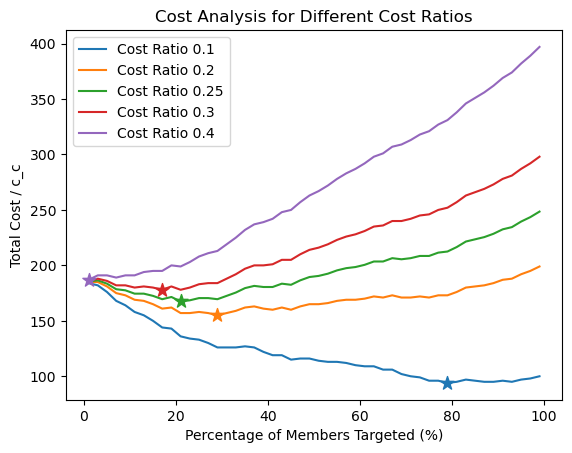

In [3]:
def calculate_cost_analysis(df_results, perfect_results_simulation=True, cost_ratios=[0.1, 0.2, 0.25, 0.3, 0.4]):
    df_results = df_results.copy()
    if perfect_results_simulation:
        df_results['prioritization_score'] = df_results['true']
    ratios_results = {ratio: [] for ratio in cost_ratios}

    df_results.sort_values(by='prioritization_score', ascending=False, inplace=True)

    percentages = np.arange(1,100,2)
    for percent in percentages:
        n = int(len(df_results)*percent/100)
        df_results_at_k = df_results.head(n)
        df_results_at_k['prioritization_score'] = 1 

        fn = df_results['true'].sum() - df_results_at_k['true'].sum() # all the positives not captured in top k
        for ratio in cost_ratios:
            # Total Cost / c_c = ( n * c_o + fn * c_c ) / c_c
            # print(f"Ratio: {ratio}, n: {n}, fn: {fn}, Total Cost / c_c: {n * ratio + fn}")
            norm_cost = n * ratio + fn
            ratios_results[ratio].append(norm_cost)
    min_percent = {ratio: (percentages[np.argmin(ratios_results[ratio])], np.min(ratios_results[ratio])) for ratio in cost_ratios}
    return ratios_results, min_percent

def plot_cost_analysis(ratios_results, min_percent):
    for ratio, costs in ratios_results.items():
        plt.plot(np.arange(1,100,2), costs, label=f'Cost Ratio {ratio}')
        plt.scatter(min_percent[ratio][0], min_percent[ratio][1], marker='*', s=100, zorder=5) # Use a star marker

    plt.xlabel('Percentage of Members Targeted (%)')
    plt.ylabel('Total Cost / c_c')
    plt.title('Cost Analysis for Different Cost Ratios')
    plt.legend()
    plt.show()

ratios_results, min_percent = calculate_cost_analysis(df_results_test, perfect_results_simulation=False)
plot_cost_analysis(ratios_results, min_percent)

In [4]:
min_percent[0.2]

(29, 155.0)

In [5]:
pc = PredictChurn(check_validation=False)
df_results_train, df_results_test = pc.train_model_and_predict(top_percentage=0.29)

In [8]:
from sklearn.metrics import precision_score
precision_at_k = precision_score(df_results_test['true'], [1]*len(df_results_test))
random_precision = df_results_test['true'].mean()
lift_at_k = precision_at_k / random_precision
lift_at_k

1.0

In [9]:
random_precision

0.2986206896551724

In [10]:
df_results_train['true'].mean()

0.2021